# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

План исследования:
 - Проведем исследовательский анализ набора фотографий.
 - Подготовим данные к обучению.
 - Обучим нейронную сеть и рассчитаем её качество.

Мы будем анализировать модель по метрике MAE, нужно получить результат не менее 8. 

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Импортируем данные в датафрейм, затем используется класс ImageDataGenerator из библиотеки Keras для генерации потока данных для обучения модели

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим размер выборки 

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Рассмотрим распределение нашей выборки по возрастам

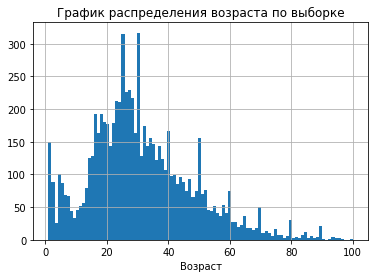

In [6]:
labels['real_age'].hist(bins=100)
plt.title('График распределения возраста по выборке')
plt.xlabel('Возраст')
plt.show()

По распределению выборки мы можем сделать вывод что после возраста 60 лет фотографий становится относительно немного. Это может быть проблемой для обучения модели

Оценим визуально несколько фотографий

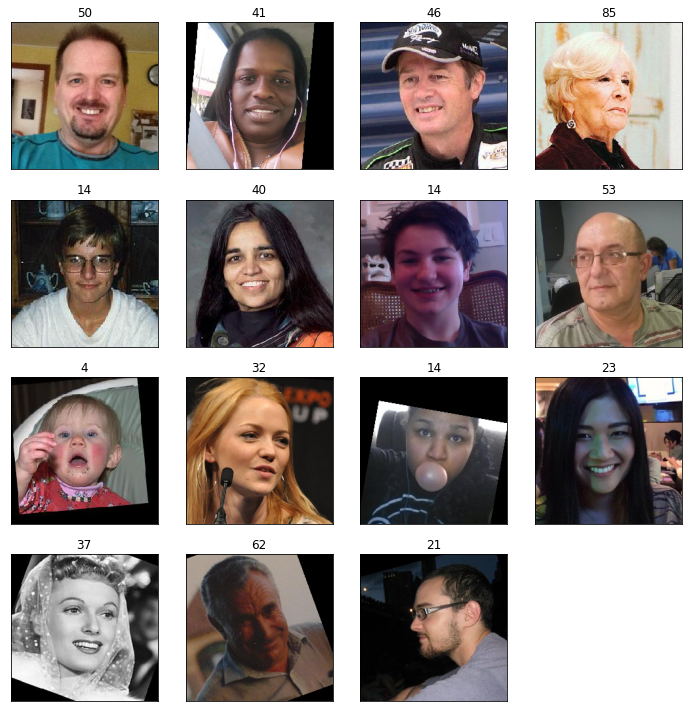

In [7]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

Все вывовдится хорошо, можем приступить к обучению модели 

## Обучение модели

Обучим модель в GPU-сервере и сохраним результат вывода модели на экран.

Результат будем оценивать по метрике MAE. Чем меньше значение, тем лучше качество модели.

In [8]:
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
 
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        horizontal_flip=True)
    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        seed=12345,
        subset='validation'
    )
    return test_gen_flow
  
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model
 
 

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

Train for 238 steps, validate for 60 steps

Epoch 1/3

238/238 - 76s - loss: 205.6899 - mae: 10.2104 - val_loss: 971.0264 - val_mae: 26.5169

Epoch 2/3

238/238 - 59s - loss: 60.6336 - mae: 5.8624 - val_loss: 519.7753 - val_mae: 17.8024

Epoch 3/3

238/238 - 57s - loss: 31.2961 - mae: 4.2501 - val_loss: 81.4067 - val_mae: 6.7674

60/60 - 10s - loss: 81.4067 - mae: 6.7674

Test MAE: 6.7674

## Анализ обученной модели

По результатам работы модели получено значение MAE равное 6.8. Это значение позволяет судить о средней абсолютной ошибке модели в прогнозировании возраста на данных. Задача по преодалению порога в 8 выполнена. 

Перед нами стояли бизнес задачи: 

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
С первой задачаей наша модель справится хорошо, так как она достаточно точно попадает в возрастную группу. 

Если говорить о второй задаче, то речь идет о молодых людях 18-21 лет, в этом случае разброс +-6.8 лет вряд ли нас может устроить. 
С другой стороны, ознакомившись со статьями я пришел к выводу что такой широкий разброс выборка дает из за недостатка данных по людям старше 60 лет, что мы так же отразили в анализе данных. В статьях указано что в возрасте 18-21 погрешность существенно меньше. 

По второму вопросу нужны дальнейшие исследования. 